In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import  keras

import wordcloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

import emoji

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



import pandas as pd
import seaborn as sns
import string 
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

2023-06-22 09:16:49.293416: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 09:16:49.356752: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 09:16:49.357708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 09:16:53.716373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brijesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brijesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [193]:
df1 = pd.read_csv("./datasets/sms.csv",delimiter=',')
df2 = pd.read_csv("datasets/yt.csv",delimiter=',')
df3 = pd.read_csv("datasets/my-collection.csv",delimiter=',')
df4 = pd.read_csv("datasets/spam-word.csv",delimiter=',')

df = pd.concat([df1,df2,df3,df4], ignore_index=True)



# df = df[["comment", "Spam"]]

df = df.drop_duplicates()
df = df.dropna()
df["Spam"]  = df["Spam"].astype(int)
df["Comment"]  = df["Comment"].astype(str)


df.head()

,Comment,Spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,1
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Preprocessing

In [217]:
df_test = pd.concat([df1,df2,df3,df4], ignore_index=True)


In [195]:
spam_words = [ "Urgent", "Exclusive", "Limited time", "Free", "Guaranteed", "Act now", "Discount", "Special offer", "Prize", "Instant",    "Cash", "Save", "Win", "Best", "Secret", "Incredible", "Congratulations", "Approved", "Risk free", "Hidden", "Bonus",    "Sale", "Amazing", "Extra cash", "Opportunity", "Easy", "Double your", "Best price", "Cash back", "Deal", "Earn",    "Money", "No obligation", "Profit", "Results", "Exciting", "Unbelievable", "Jackpot", "Fantastic", "Instant access",    "Million dollars", "Discounted", "Last chance", "Exclusive offer", "Big savings", "Limited offer", "Free trial",    "Special promotion", "Secret revealed", "Valuable", "Money-back guarantee", "Lowest price", "Save money", "Make money",    "No risk", "Exclusive deal", "Limited supply", "Huge", "Incredible offer", "Prize winner", "Earn extra income",    "Limited spots", "New offer", "Best deal", "Don't miss out", "Great savings", "Top offer", "Double your income",    "Discount code", "Fast cash", "Top-rated", "Best value", "No cost", "Elite", "Act fast", "Unbeatable", "Cash prize",    "Limited availability", "Special discount", "Quick cash", "No catch", "Instant approval", "Big discount", "Easy money",    "Insider", "Invitation", "Free shipping", "Huge discount", "Extra income", "Secret formula", "No strings attached",    "Money-making", "Dream come true", "Massive", "Free gift", "Incredible opportunity", "Risk-free trial", "Instant money",    "Special price", "No purchase necessary"]


In [196]:
pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
df['Comment'] = df['Comment'].apply(lambda text: " ".join([word.lower() for word in pattern.sub('', text.lower().strip()).split() if word.lower() not in set(stopwords.words('english'))]))

In [197]:
df['length'] = df['Comment'].str.len().astype(int)
df['currency']=df['Comment'].str.contains('₤|₨|€|₹|₿|$',regex=False).astype(int)
df['spam_word']=df['Comment'].str.contains('|'.join(i.lower().strip() for i in spam_words ),regex=True).astype(int)
df["emoji"] = df['Comment'].str.contains('💭|🔝|🆗|🎉|🎊|📯|🙌|😂|💸|👉|📢|🚀|💲|💣|🔱|💼|🆙|⏳|✨|💌|💎|🆕|🔞|💡|💰|👑|⭐|🌟|🎤|⚡|📈|💵|🏆|💪|🔓|🆓|🎰|⌚|🚨|💢|📮|🔥|🎈|🎥|🔔|💯|🎶|🔗|🎁|📚|🔊|👍|👏|📱|📝|🤑|🏅|🔒|📣|💥').astype(int)

df['contain']=df['Comment'].str.contains('[0-9]*%|T&C',regex=True).astype(int)
df['contain']=df['contain'] | df['Comment'].str.contains(r"https?://\S+|www\.\S+",regex=True).astype(int)
df['contain']=df['contain'] | df['Comment'].str.contains("free|Free").astype(int)

df['email']=df['Comment'].str.contains(r"[\w]+@[\w]+\.\w+",regex=True).astype(int)
df['phone']=df['Comment'].str.contains(r"\+?[0-9]?[0-9]? ?0?[0-9]{10}",regex=True).astype(int)


In [198]:


# df["emoji"] = df['Comment'].str.contains('💭|🔝|🆗|🎉|🎊|📯|🙌|😂|💸|👉|📢|🚀|💲|💣|🔱|💼|🆙|⏳|✨|💌|💎|🆕|🔞|💡|💰|👑|⭐|🌟|🎤|⚡|📈|💵|🏆|💪|🔓|🆓|🎰|⌚|🚨|💢|📮|🔥|🎈|🎥|🔔|💯|🎶|🔗|🎁|📚|🔊|👍|👏|📱|📝|🤑|🏅|🔒|📣|💥').astype(int)

# df["flag"] = df['Comment'].str.contains('🇦🇫|🇦🇱|🇩🇿|🇦🇩|🇦🇴|🇦🇷|🇦🇲|🇦🇼|🇦🇺|🇦🇹|🇦🇿|🇧🇸|🇧🇭|🇧🇩|🇧🇧|🇧🇾|🇧🇪|🇧🇿|🇧🇯|🇧🇲|🇧🇹|🇧🇴|🇧🇦|🇧🇼|🇧🇷|🇧🇳|🇧🇬|🇧🇫|🇧🇮|🇨🇻|🇰🇭|🇨🇲|🇨🇦|🇮🇨|🇰🇾|🇨🇫|🇹🇩|🇨🇱|🇨🇳|🇨🇽|🇨🇨|🇨🇴|🇰🇲|🇨🇬|🇨🇩|🇨🇰|🇨🇷|🇨🇮|🇭🇷|🇨🇺|🇨🇼|🇨🇾|🇨🇿|🇩🇰|🇩🇯|🇩🇲|🇩🇴|🇪🇨|🇪🇬|🇸🇻|🇬🇶|🇪🇷|🇪🇪|🇪🇹|🇫🇰|🇫🇴|🇫🇯|🇫🇮|🇫🇷|🇬🇫|🇵🇫|🇹🇫|🇬🇦|🇬🇲|🇬🇪|🇩🇪|🇬🇭|🇬🇮|🇬🇷|🇬🇱|🇬🇩|🇬🇵|🇬🇺|🇬🇹|🇬🇬|🇬🇳|🇬🇼|🇬🇾|🇭🇹|🇭🇳|🇭🇰|🇭🇺|🇮🇸|🇮🇳|🇮🇩|🇮🇷|🇮🇶|🇮🇪|🇮🇲|🇮🇱|🇮🇹|🇯🇲|🇯🇵|🇯🇪|🇯🇴|🇰🇿|🇰🇪|🇰🇮|🇽🇰|🇰🇼|🇰🇬|🇱🇦|🇱🇻|🇱🇧|🇱🇸|🇱🇷|🇱🇾|🇱🇮|🇱🇹|🇱🇺|🇲🇴|🇲🇰|🇲🇬|🇲🇼|🇲🇾|🇲🇻|🇲🇱|🇲🇹|🇲🇭|🇲🇶|🇲🇷|🇲🇺|🇾🇹|🇲🇽|🇫🇲|🇲🇩|🇲🇨|🇲🇳|🇲🇪|🇲🇸|🇲🇦|🇲🇿|🇲🇲|🇳🇦|🇳🇷|🇳🇵|🇳🇱|🇳🇨|🇳🇿|🇳🇮|🇳🇪|🇳🇬|🇳🇺|🇳🇫|🇲🇵|🇰🇵|🇳🇴|🇴🇲|🇵🇰|🇵🇼|🇵🇸|🇵🇦|🇵🇬|🇵🇾|🇵🇪|🇵🇭|🇵🇳|🇵🇱|🇵🇹|🇵🇷|🇶🇦|🇷🇴|🇷🇺|🇷🇼|🇧🇱|🇸🇭|🇰🇳|🇱🇨|🇲🇫|🇵🇲|🇻🇨|🇼🇸|🇸🇲|🇸🇹|🇸🇦|🇸🇳|🇷🇸|🇸🇨|🇸🇱|🇸🇬|🇸🇽|🇸🇰|🇸🇮|🇸🇧|🇸🇴|🇿🇦|🇬🇸|🇰🇷|🇸🇸|🇪🇸|🇱🇰|🇸🇩|🇸🇷|🇸🇯|🇸🇿|🇸🇪|🇨🇭|🇸🇾|🇹🇼|🇹🇯|🇹🇿|🇹🇭|🇹🇱|🇹🇬|🇹🇰|🇹🇴|🇹🇹|🇹🇳|🇹🇷|🇹🇲|🇹🇨|🇹🇻|🇺🇬|🇺🇦|🇦🇪|🇬🇧|🇺🇸|🇺🇾|🇺🇿|🇻🇺|🇻🇦|🇻🇪|🇻🇳|🇻🇮|🇻🇬|🇼🇫|🇪🇭|🇾🇪|🇿🇲|🇿🇼').map({False:0,True:1})

df['contain']=df['Comment'].str.contains('[0-9]*%|T&C',regex=True).astype(int)
df['contain']=df['contain'] | df['Comment'].str.contains(r"https?://\S+|www\.\S+",regex=True).astype(int)
df['contain']=df['contain'] | df['Comment'].str.contains("free|Free").astype(int)

df['email']=df['Comment'].str.contains(r"[\w]+@[\w]+\.\w+",regex=True).astype(int)
df['phone']=df['Comment'].str.contains(r"\+?[0-9]?[0-9]? ?0?[0-9]{10}",regex=True).astype(int)


df.head()

,Comment,Spam,length,currency,spam_word,emoji,contain,email,phone
0,go jurong point crazy available bugis n great ...,0,82,0,0,0,0,0,0
1,ok lar joking wif u oni,1,23,0,0,0,0,0,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1,135,0,1,0,1,0,1
3,u dun say early hor u c already say,0,35,0,0,0,0,0,0
4,nah dont think goes usf lives around though,0,43,0,0,0,0,0,0


Remove

In [199]:
df["Comment"] = df["Comment"].map(lambda  text :  re.compile(r"(\+[0-9]{2})? ?\d{10}").sub(r"", text) )
df["Comment"] = df["Comment"].map(lambda  text :  re.compile(r"[\w]+@[\w]+\.\w+").sub(r"", text) )
df["Comment"] = df["Comment"].map(lambda  text :  re.compile(r"https?://\S+|www\.\S+").sub(r"", text))
df["Comment"] = df["Comment"].map(lambda  text :  emoji.replace_emoji(text))

wordlem=nltk.WordNetLemmatizer()

df["Comment"] = df["Comment"].map(lambda text : " ".join([wordlem.lemmatize(i.strip()) for i in re.split("\W+",text) ]))
df["Comment"] = df["Comment"].map(lambda  text :  text.strip() )


In [8]:
y=pd.DataFrame(df.Spam)
x=df.drop(["Spam"],axis=1)

In [9]:
print(df['Comment'][0])


go jurong point crazy available bugis n great world la e buffet cine got amore wat


In [10]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=0)


In [11]:
# tokenizer = Tokenizer()

# tokenizer.fit_on_texts(x_train['Comment'])

# train_string_sequences = tokenizer.texts_to_sequences(x_train['Comment'])
# test_string_sequences = tokenizer.texts_to_sequences(x_test['Comment'])

# max_string_sequence_length = 5000
# train_string_data = pad_sequences(train_string_sequences, maxlen=max_string_sequence_length)
# test_string_data = pad_sequences(test_string_sequences, maxlen=max_string_sequence_length)



In [12]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")

2023-06-22 09:17:28.800273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-22 09:17:28.851908: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
train_string_data = embed(x_train['Comment'])
test_string_data = embed(x_test["Comment"])


2023-06-22 09:17:29.544951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sentences' with dtype string and shape [?]
	 [[{{node sentences}}]]


In [71]:
# # input_data = {column: x_train[column].values for column in x_train.columns}
# # input_data_test = {column: x_val[column].values for column in x_val.columns}
X_train=pd.DataFrame([x_train["Comment"],x_train["length"],x_train["currency"] , x_train["spam_word"] , x_train["emoji"] , x_train["contain"], x_train["email"], x_train["phone"]])
X_test=pd.DataFrame ( [x_test["Comment"], x_test["length"],x_test["currency"] , x_test["spam_word"] , x_test["emoji"] , x_test["contain"], x_test["email"], x_test["phone"]])
#,currency_input,spam_word_input,emoji_input,email_input,phone_input
#

(17308, 8)
(17308, 1)
(4327, 8)
(4327, 1)


In [16]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", dtype=tf.string, trainable=True,name="hub")


In [17]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [73]:

string_input = tf.keras.layers.Input(shape=[], dtype=tf.string,name="input string")
embedding_layer = hub_layer(string_input)
s1= tf.keras.layers.Dense(2500, activation='relu')(embedding_layer)
s2 = tf.keras.layers.Dense(100, activation='relu')(s1)
s3 = tf.keras.layers.Dense(50, activation='relu')(s2)
flatten_layer = tf.keras.layers.Flatten(name="flatten_layer")(s3)


length_input = tf.keras.layers.Input(shape=(1,))
length_layer = tf.keras.layers.Dense(256, activation='relu',name="length_layer")(length_input)

currency_input = tf.keras.layers.Input(shape=(1,))
currency_layer = tf.keras.layers.Dense(2, activation='relu',name="currency_layer")(currency_input)

spam_word_input = tf.keras.layers.Input(shape=(1,))
spam_word_layer = tf.keras.layers.Dense(2, activation='relu',name="spam_word_layer")(spam_word_input)

emoji_input = tf.keras.layers.Input(shape=(1,))
emoji_layer = tf.keras.layers.Dense(2, activation='relu',name="emoji_layer")(emoji_input)

contain_input = tf.keras.layers.Input(shape=(1,))
contain_layer = tf.keras.layers.Dense(2, activation='relu',name="conatian_layer")(contain_input)


email_input = tf.keras.layers.Input(shape=(1,))
email_layer = tf.keras.layers.Dense(2, activation='relu',name="email_layer")(email_input)


phone_input = tf.keras.layers.Input(shape=(1,))
phone_layer = tf.keras.layers.Dense(2, activation='relu',name="phone_layer")(phone_input)

concat_layer_level1_1 = tf.keras.layers.concatenate([length_layer,currency_layer,spam_word_layer])
concat_layer_level1_2 = tf.keras.layers.concatenate([contain_layer,emoji_layer,email_layer,phone_layer])

concat_layer_level1_1_dense = tf.keras.layers.Dense(6, activation='relu',name="concat_layer_level1_1_dense")(concat_layer_level1_1)
concat_layer_level1_2_dense = tf.keras.layers.Dense(8, activation='relu',name="concat_layer_level1_2_dense")(concat_layer_level1_2)

concat_layer_level = tf.keras.layers.concatenate([concat_layer_level1_1_dense,concat_layer_level1_2_dense])
sub_layer = tf.keras.layers.Dense(48, activation='relu',name="sub_layer")(concat_layer_level)
con  = tf.keras.layers.Dropout(rate=0.2)(sub_layer)


# Concatenate all input branches
concat_layer = tf.keras.layers.concatenate([flatten_layer,con ])

# Add dense and output layers
f1= tf.keras.layers.Dense(300, activation='relu')(concat_layer)
f2 = tf.keras.layers.Dense(150, activation='relu')(f1)
f3 = tf.keras.layers.Dense(100, activation='relu')(f2)

dense_layer = tf.keras.layers.Dense(64, activation='relu',name="dense")(f3)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid',name="output")(dense_layer)

# Create the model
model = tf.keras.Model(inputs=[string_input, length_input,currency_input,spam_word_input,emoji_input,contain_input,email_input,phone_input], outputs=output_layer)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=[])
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_51 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_52 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_54 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

2023-06-22 11:25:34.784718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


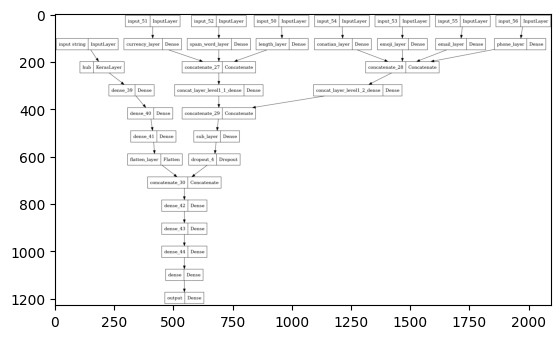

In [74]:

# model = "https://tfhub.dev/google/nnlm-en-dim50/2"
# hub_layer = hub.KerasLayer(model, dtype=tf.string, trainable=True,name="hub")

# # nnlm_model = tf.saved_model.load("./models/nnlm-en-dim50_2")

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(8,1),name="Input_layer"),   
#     embed,
#     tf.keras.layers.Dense(300, activation='relu'),
#     tf.keras.layers.Dense(150, activation='relu'),
#     tf.keras.layers.Dense(100, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.build()
# model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
# print(model.summary())

from tensorflow.keras.utils import plot_model

# Plot model
plot_model(model, to_file='team_strength_model.png')

# Display the image
data = plt.imread('team_strength_model.png')
plt.imshow(data);

In [81]:
k = model.fit(x_train,
          y_train,
          epochs=1,
          batch_size=512,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)]
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [63]:
model.evaluate([X_test],y_test)

136/136 [==============================] - 8s 60ms/step - loss: 0.1831 - accuracy: 0.9485


[0.18309266865253448, 0.9484631419181824]

pandas.core.frame.DataFrame

In [68]:

# Prepare example input data
string_input_data = np.array(["free money"]).astype(str) 
length_input_data = np.array([20]).astype(int)  # Example length value
currency_input_data = np.array([0]).astype(int)  # Example currency value
spam_word_input_data = np.array([1]).astype(int)  # Example spam word value
emoji_input_data = np.array([1]).astype(int)  # Example emoji value
contain_input_data = np.array([0]).astype(int)  # Example containment value
email_input_data = np.array([0]).astype(int)  # Example email value
phone_input_data = np.array([0]).astype(int)  # Example phone value



# Pass the input data to the model for predict
# ion
predictions = model.predict([string_input_data, length_input_data, currency_input_data, spam_word_input_data,
                             emoji_input_data, contain_input_data, email_input_data, phone_input_data])

print(predictions)


1/1 [==============================] - 0s 67ms/step
[[0.9108964]]


In [30]:
cv=CountVectorizer(max_features=5000)
temp_train=cv.fit_transform(x_train['Comment']).toarray()
temp_val=cv.transform(x_val['Comment']).toarray()

tf=TfidfTransformer()
temp_train=tf.fit_transform(temp_train)
temp_val=tf.transform(temp_val)

temp_train=pd.DataFrame(temp_train.toarray(),index=x_train.index)
temp_val=pd.DataFrame(temp_val.toarray(),index=x_val.index)
x_train=pd.concat([x_train,temp_train],axis=1,sort=False)
x_val=pd.concat([x_val,temp_val],axis=1,sort=False)

x_train.drop(['Comment'],axis=1,inplace=True)
x_val.drop(['Comment'],axis=1,inplace=True)



NameError: name 'x_val' is not defined

In [36]:
x_train.columns = x_train.columns.astype(str)
x_val.columns = x_val.columns.astype(str)        

In [37]:
y_train=y_train.astype(int)
y_val=y_val.astype(int)

In [39]:
model=MultinomialNB()
model.fit(x_train,y_train)
y_preds=model.predict(["dad"])
print("Multinomial Naive Bayes:",accuracy_score([1],y_preds))

/home/brijesh/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/brijesh/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=['dad'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [114]:
model=DecisionTreeClassifier(random_state=0)
model.fit(x_train,y_train)
y_preds=model.predict(x_val)
print("Decision Tree:",accuracy_score(y_val,y_preds))

Decision Tree: 0.953782534663099


In [115]:
model=RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(x_train,y_train)
y_preds=model.predict(x_val)
print("Random Forest:",accuracy_score(y_val,y_preds))

/tmp/ipykernel_1921/2502017040.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


Random Forest: 0.9778642666018


In [ ]:
training_size = int(len(df) * 0.8)
vocab_size=50000
embedding_dim=32
max_length=1000


training_sentences = df["Comment"][0:training_size]
testing_sentences = df["Comment"][training_size:]
training_labels = df["Spam"][0:training_size]
testing_labels = df["Spam"][training_size:]

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<00V>")
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=1000, padding="post", truncating="post")

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=1000, padding="post", truncating="post")

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

2023-06-18 23:24:57.945584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-18 23:24:58.044037: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          1600000   
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                        

In [ ]:
num_epochs = 10

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
514/514 - 13s - loss: 0.2194 - accuracy: 0.9555 - val_loss: 0.5757 - val_accuracy: 0.7796 - 13s/epoch - 25ms/step
Epoch 2/10
514/514 - 12s - loss: 0.2039 - accuracy: 0.9555 - val_loss: 0.6010 - val_accuracy: 0.7796 - 12s/epoch - 24ms/step
Epoch 3/10
514/514 - 13s - loss: 0.1943 - accuracy: 0.9555 - val_loss: 0.6258 - val_accuracy: 0.7796 - 13s/epoch - 24ms/step
Epoch 4/10
514/514 - 12s - loss: 0.1886 - accuracy: 0.9555 - val_loss: 0.6488 - val_accuracy: 0.7796 - 12s/epoch - 24ms/step
Epoch 5/10
514/514 - 12s - loss: 0.1853 - accuracy: 0.9555 - val_loss: 0.6687 - val_accuracy: 0.7796 - 12s/epoch - 24ms/step
Epoch 6/10
514/514 - 12s - loss: 0.1835 - accuracy: 0.9555 - val_loss: 0.6853 - val_accuracy: 0.7796 - 12s/epoch - 24ms/step
Epoch 7/10
514/514 - 13s - loss: 0.1825 - accuracy: 0.9555 - val_loss: 0.6987 - val_accuracy: 0.7796 - 13s/epoch - 24ms/step
Epoch 8/10
514/514 - 12s - loss: 0.1821 - accuracy: 0.9555 - val_loss: 0.7078 - val_accuracy: 0.7796 - 12s/epoch - 24ms/step


In [78]:
k.

{'loss': [0.08349471539258957, 0.06279651820659637],
 'accuracy': [0.9700138568878174, 0.9772359728813171],
 'val_loss': [0.1213839203119278, 0.14979007840156555],
 'val_accuracy': [0.9581696391105652, 0.9593251943588257]}

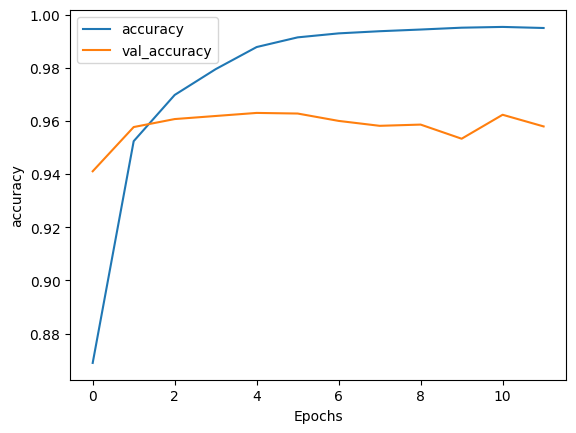

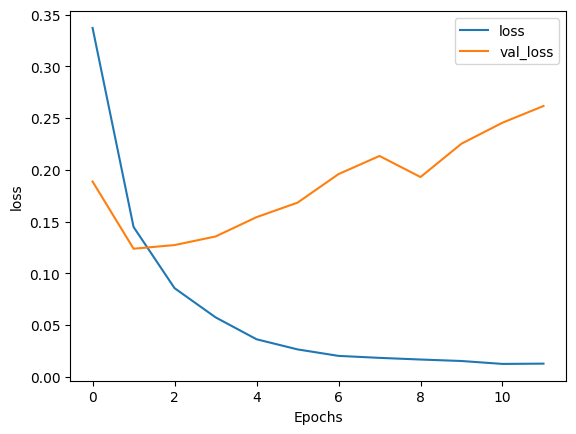

In [21]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(k, "accuracy")
plot_graphs(k, "loss")

In [ ]:
# sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
# sequences = tokenizer.texts_to_sequences(sentence)
# padded = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")
print(model.evaluate(testing_padded,testing_labels))

129/129 [==============================] - 0s 2ms/step - loss: 0.7165 - accuracy: 0.7796
[0.7164579033851624, 0.7796156406402588]


In [240]:
from sklearn.pipeline import Pipeline



class ConvertData:
    
    def fit(self,x,y=None):
        return self
    
    def transform(self, df):
        df = df.drop_duplicates()
        df = df.dropna()
        df["Spam"]  = df["Spam"].astype(int)
        df["Comment"]  = df["Comment"].astype(str)
        return df


class RemoveStopWordsPunctuation:
    
    def fit(self,x,y=None):
        return self
    
    def __remove_punctuation_stopwords(self,text):
        pattern = re.compile('[{}]'.format(re.escape('!"#&\'()*,-/:;<=>?[\\]^_`{|}~')))
        text = " ".join([word.strip() for word in pattern.sub(' ', text.lower()).split() if word not in set(stopwords.words('english'))])
        return text


    def transform(self, df):
        df['Comment'] = df['Comment'].apply(self.__remove_punctuation_stopwords)
        return df



class AddLengthFlag:
    
    def fit(self,x,y=None):
        return self
    
    def transform(self, X):
        X['length'] = X['Comment'].str.len().astype(int)
        return X


class AddCurrencyFlag:

    def __init__(self) -> None:
        self.currency_symbols = ['₤', '₨', '€', '₹', '₿', '$']
    
    def fit(self,x,y=None):
        return self
    
    def __add_currency_count(self,text):
        return sum(text.count(symbol) for symbol in self.currency_symbols )

    def transform(self, df):
        df['currency']=df['Comment'].apply(self.__add_currency_count)
        return df
    

class AddSpamWordsFlag:

    def __init__(self) -> None:
        self.spam_words = [ "Urgent", "Exclusive", "Limited time", "Free", "Guaranteed", "Act now", "Discount", "Special offer", "Prize", "Instant",    "Cash", "Save", "Win", "Best", "Secret", "Incredible", "Congratulations", "Approved", "Risk free", "Hidden", "Bonus",    "Sale", "Amazing", "Extra cash", "Opportunity", "Easy", "Double your", "Best price", "Cash back", "Deal", "Earn",    "Money", "No obligation", "Profit", "Results", "Exciting", "Unbelievable", "Jackpot", "Fantastic", "Instant access",    "Million dollars", "Discounted", "Last chance", "Exclusive offer", "Big savings", "Limited offer", "Free trial",    "Special promotion", "Secret revealed", "Valuable", "Money-back guarantee", "Lowest price", "Save money", "Make money",    "No risk", "Exclusive deal", "Limited supply", "Huge", "Incredible offer", "Prize winner", "Earn extra income",    "Limited spots", "New offer", "Best deal", "Don't miss out", "Great savings", "Top offer", "Double your income",    "Discount code", "Fast cash", "Top-rated", "Best value", "No cost", "Elite", "Act fast", "Unbeatable", "Cash prize",    "Limited availability", "Special discount", "Quick cash", "No catch", "Instant approval", "Big discount", "Easy money",    "Insider", "Invitation", "Free shipping", "Huge discount", "Extra income", "Secret formula", "No strings attached",    "Money-making", "Dream come true", "Massive", "Free gift", "Incredible opportunity", "Risk-free trial", "Instant money",    "Special price", "No purchase necessary"]

    def fit(self,x,y=None):
        return self
    
    def __add_currency_count(self,text):
        return sum(text.count(symbol) for symbol in self.spam_words )

    def transform(self, df):
        df['spam_word']=df['Comment'].apply(self.__add_currency_count)
        return df



class AddEmojiFlag:

    def __init__(self) -> None:
        self.emoji_symbols = '💭|🔝|🆗|🎉|🎊|📯|🙌|😂|💸|👉|📢|🚀|💲|💣|🔱|💼|🆙|⏳|✨|💌|💎|🆕|🔞|💡|💰|👑|⭐|🌟|🎤|⚡|📈|💵|🏆|💪|🔓|🆓|🎰|⌚|🚨|💢|📮|🔥|🎈|🎥|🔔|💯|🎶|🔗|🎁|📚|🔊|👍|👏|📱|📝|🤑|🏅|🔒|📣|💥'
    
    def fit(self,x,y=None):
        return self
    
    def __add_currency_count(self,text):
        pattern = '[' + re.escape(self.emoji_symbols) + ']'
        return len(re.findall(pattern, text))

    def transform(self, df):
        df['emoji']=df['Comment'].apply(self.__add_currency_count)
        return df

class AddContainFlag:

    def fit(self,x,y=None):
        return self
    
    def __add_first_count(self,text):
        pattern = '[0-9]*%|T&C'
        return len(re.findall(pattern, text))
    
    def __add_second_count(self,text):
        pattern = 'https?://\S+|www\.\S+'
        return len(re.findall(pattern, text))
    

    def transform(self, df):
        df['contain']=df['Comment'].apply(self.__add_first_count)
        df['contain']=df['Comment'].apply(self.__add_second_count)
        return df

class AddEmailFlag:

    def fit(self,x,y=None):
        return self
    
    def __add_email_count(self,text):
        pattern = '[\w]+@[\w]+\.\w+'
        return len(re.findall(pattern, text))
    


    def transform(self, df):
        df['email']=df['Comment'].apply(self.__add_email_count)
        return df

class AddPhoneFlag:

    def fit(self,x,y=None):
        return self
    
    def __add_phone_no_count(self,text):
        pattern = '\+?[0-9]?[0-9]? ?0?[0-9]{10}'
        return len(re.findall(pattern, text))
    

    def transform(self, df):
        df['phone']=df['Comment'].apply(self.__add_phone_no_count)
        return df


class RemovePhoneLinkEmail:

    def fit(self,x,y=None):
        return self
    
    def __remove(self,text):
        text = re.sub(r"(\+[0-9]{2})? ?\d{10}", "", text)
        text = re.sub(r"https?://\S+|www\.\S+", "", text)
        text = re.sub(r"[\w]+@[\w]+\.\w+", "", text)
        text = emoji.replace_emoji(text)
        return text 

    def transform(self, df):
        df['Comment']=df['Comment'].apply(self.__remove)
        return df

class LemmatizeText:
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def __lemmatize_text(self, text):
        return " ".join([self.lemmatizer.lemmatize(word) for word in re.split("\W+", text)]).strip()

    def transform(self, df):
        df['Comment'] = df['Comment'].map(lambda text: self.__lemmatize_text(text))
        return df




In [241]:


pipe =  Pipeline([
    ("ConvertData",ConvertData()),
    ("RemoveStopWordsPunctuation",RemoveStopWordsPunctuation()),

    ("AddCurrencyFlag",AddCurrencyFlag()),
    ("AddSpamWordsFlag",AddSpamWordsFlag()),
    ("AddEmojiFlag",AddEmojiFlag()),
    ("AddContainFlag",AddContainFlag()),
    ("AddEmailFlag",AddEmailFlag()),
    ("AddPhoneFlag",AddPhoneFlag()),

    ("RemovePhoneLinkEmail",RemovePhoneLinkEmail()),
    
    ("LemmatizeText",LemmatizeText()),

    ("AddLengthFlag",AddLengthFlag()),



])


In [242]:

d = pipe.transform(df_test)
# Function to remove punctuation and stopwords from a text


In [227]:
df

,Comment,Spam,length,currency,spam_word,emoji,contain,email,phone
0,go jurong point crazy available bugis n great ...,0,82,0,0,0,0,0,0
1,ok lar joking wif u oni,1,23,0,0,0,0,0,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1,135,0,1,0,1,0,1
3,u dun say early hor u c already say,0,35,0,0,0,0,0,0
4,nah dont think go usf life around though,0,43,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
21632,status,1,6,0,0,0,0,0,0
21633,believe eye,1,12,0,0,0,0,0,0
21634,zero chance,1,11,0,0,0,0,0,0
21635,zero percent,1,12,0,0,0,0,0,0


In [244]:
d = d.reindex(columns=['Comment',	'Spam'	,'length',	'currency',	'spam_word',	'emoji'	,'contain',	'email',	'phone'])


In [245]:
d.to_csv("d.csv")

In [144]:
pattern = re.compile('[{}]'.format(re.escape('!"#&\'()*,-/:;<=>?[\\]^_`{|}~')))
" ".join([word.lower() for word in pattern.sub('', "dadad@d.ca".lower().strip()).split() if word.lower() not in set(stopwords.words('english'))])

'dadad@d.ca'

In [248]:
from enchant.checker import SpellChecker

def detect_spelling_mistakes(text):
    spell_checker = SpellChecker("en_US")
    spell_checker.set_text(text)
    
    for error in spell_checker:
        print("Spelling mistake:", error.word)

detect_spelling_mistakes("dadad")

ModuleNotFoundError: No module named 'enchant'

In [235]:
from sklearn.pipeline import make_pipeline
from joblib import Parallel, delayed

# Define a function to execute a transformer in parallel
def parallel_transform(transformer, X):
    return Parallel(n_jobs=-1)(delayed(transformer.transform)(chunk) for chunk in np.array_split(X, n_jobs))

# Set the number of parallel jobs
n_jobs = 4  # Adjust the number of parallel jobs as per your system's capabilities

# Define your pipeline
pipe = make_pipeline(
    ConvertData(),
    RemoveStopWordsPunctuation(),
    AddLengthFlag(),
    AddCurrencyFlag(),
    AddEmojiFlag(),
    AddContainFlag(),
    AddSpamWordsFlag(),
    AddEmailFlag(),
    AddPhoneFlag(),
    RemovePhoneLinkEmail(),
    LemmatizeText()
)

# Parallelize the pipeline transformations
def parallel_pipeline_transform(X):
    return parallel_transform(pipe, X)

# Call the parallel_pipeline_transform function to transform your data in parallel
transformed_data = parallel_pipeline_transform(df_test)


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.